# Named Entity Recognition for Identifying Key Elements in Mobile Game Ads

In [1]:
import pandas as pd
import spacy
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tqdm import tqdm
import ast
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
!python -m spacy download en_core_web_lg
nlp = spacy.load('en_core_web_lg')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
# Function to extract named entities from text
def get_entities_from_text(text):
    entities_dict = {}
    doc = nlp(text)
    for entity in doc.ents:
        label = entity.label_
        if label not in entities_dict:
            entities_dict[label] = set()
        entities_dict[label].add(entity.text)
    return entities_dict
tqdm.pandas(desc="Extracting Named Entities")

In [7]:
# Define path inside Google Drive
save_path = "/content/drive/MyDrive/Youtube_Game_Ads/Reviews/Ads_Related/"
os.makedirs(save_path, exist_ok=True)
hero_wars = pd.read_csv(save_path + "hero_wars_ad_reviews.csv")
puzzles_and_survival = pd.read_csv(save_path + "Puzzles_and_survival_ad_reviews.csv")
project_makeover = pd.read_csv(save_path + "project_makeover_ad_reviews.csv")
hustle_castle = pd.read_csv(save_path + "hustle_castle_ad_reviews.csv")
last_fortress = pd.read_csv(save_path + "last_fortress_ad_reviews.csv")

In [8]:
puzzles_and_survival["entities_dict"] = puzzles_and_survival["content"].progress_apply(get_entities_from_text)
project_makeover["entities_dict"] = project_makeover["content"].progress_apply(get_entities_from_text)
hustle_castle["entities_dict"] = hustle_castle["content"].progress_apply(get_entities_from_text)
hero_wars["entities_dict"] = hero_wars["content"].progress_apply(get_entities_from_text)
last_fortress["entities_dict"] = last_fortress["content"].progress_apply(get_entities_from_text)

Extracting Named Entities: 100%|██████████| 838/838 [00:12<00:00, 67.58it/s]


In [17]:
merged_df = pd.concat([hero_wars, puzzles_and_survival, project_makeover, hustle_castle, last_fortress], ignore_index=True)

In [18]:
# Convert 'entities_dict' column back to dictionaries if they are stored as strings
puzzles_and_survival["entities_dict"] = merged_df["entities_dict"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Collect all unique entity types
all_entity_types = set()
for entity_dict in puzzles_and_survival["entities_dict"]:
    if isinstance(entity_dict, dict):  # Ensure it's a dictionary
        for entity_type in entity_dict.keys():
            all_entity_types.add(entity_type)

print("Entity types found in dataset:", all_entity_types)

Entity types found in dataset: {'GPE', 'PRODUCT', 'DATE', 'FAC', 'CARDINAL', 'ORG', 'PERSON', 'QUANTITY', 'NORP', 'LOC', 'PERCENT', 'WORK_OF_ART', 'LAW', 'ORDINAL', 'TIME', 'EVENT', 'MONEY'}


In [23]:
def draw_word_cloud_for_entity(ad_reviews_df, entity_type=None, min_times=5):
    """Generates a word cloud for a specific named entity type or all entity types combined."""

    # Collect all entity mentions
    entity_list = []

    for entity_dict in ad_reviews_df["entities_dict"]:
        if isinstance(entity_dict, dict):  # Ensure it's a valid dictionary
            if entity_type:
                # Extract specific entity type
                if entity_type in entity_dict:
                    entity_list += list(entity_dict[entity_type])
            else:
                # Extract all entity types
                for entities in entity_dict.values():
                    entity_list += list(entities)

    # Generate Word Cloud
    wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10)

    # Count occurrences and filter based on min_times threshold
    c = Counter(entity_list)
    entity_freq = {k: v for k, v in c.items() if v > min_times}

    if not entity_freq:
        msg = f"No entities found with at least {min_times} occurrences." if not entity_type else f"No {entity_type} entities found with at least {min_times} occurrences."
        print(msg)
        return

    wordcloud.generate_from_frequencies(entity_freq)

    # Display Word Cloud
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    title = f"Word Cloud of {entity_type} Entities" if entity_type else "Word Cloud of All Entities"
    plt.title(title)
    plt.show()

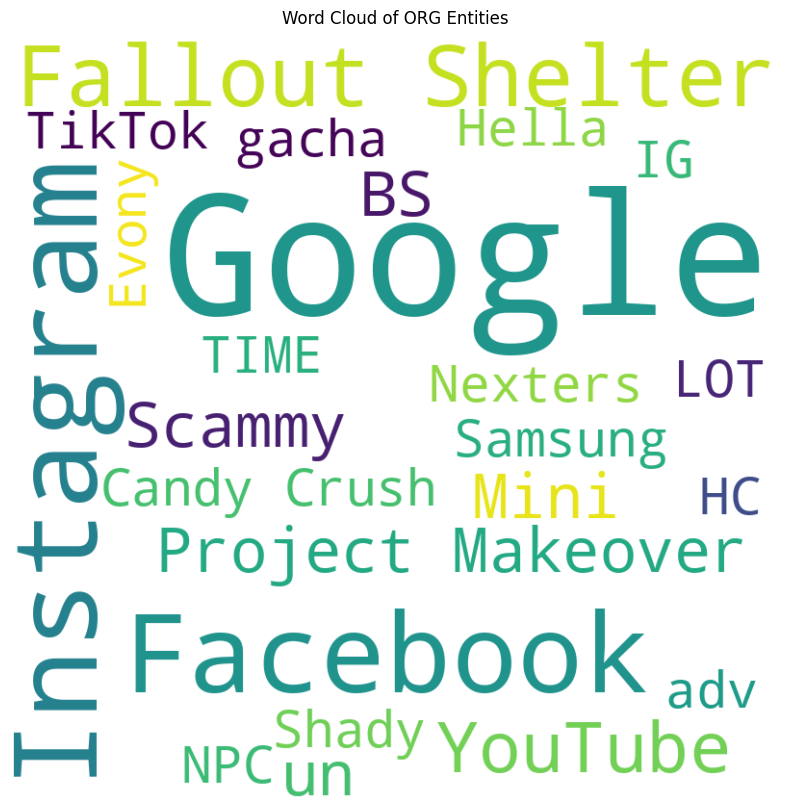

In [34]:
draw_word_cloud_for_entity(merged_df, min_times=1, entity_type='ORG')